In [1]:
import pandas as pd
import numpy as np
import pyarrow as pa

import pyarrow.csv as csv

In [2]:
DATA_DIR = '/kaggle/input/wisdom/'

In [3]:
train_df = csv.read_csv(DATA_DIR + "train.csv").to_pandas()
#test_df = csv.read_csv(DATA_DIR + "test.csv").to_pandas()

In [4]:
members_df = csv.read_csv(DATA_DIR + "members.csv").to_pandas()
songs_df = csv.read_csv(DATA_DIR + "songs.csv").to_pandas()
songs_extra_df = csv.read_csv(DATA_DIR + "song_extra_info.csv").to_pandas()

# Data Exploration

In [5]:
train_df.shape

(7377418, 6)

In [6]:
train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [7]:
train_df.dtypes

msno                  object
song_id               object
source_system_tab     object
source_screen_name    object
source_type           object
target                 int64
dtype: object

msno is user_id, source features represent the mobile app.

In [8]:
print(f'unique users: {train_df.msno.unique().shape[0]}')

unique users: 30755


In [9]:
train_song_counts = train_df.song_id.value_counts().mean()
print(f'average number of song relistens: {train_song_counts}')

average number of song relistens: 20.494763394320575


In [10]:
train_df.target.value_counts()

target
1    3714656
0    3662762
Name: count, dtype: int64

target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event.

Balanced distrubition of positive and negative interactions, this is unusual but nice.

In [11]:
train_df.source_system_tab.value_counts()

source_system_tab
my library      3684730
discover        2179252
search           623286
radio            476701
listen with      212266
explore          167949
                  18371
null               6478
notification       6185
settings           2200
Name: count, dtype: int64

In [12]:
train_source = train_df[['source_system_tab', 'target']]
dummies_source = pd.get_dummies(train_source)
corr = dummies_source.corr()
sorted_corrs = corr['target'].sort_values(ascending=False)
sorted_corrs

target                            1.000000
source_system_tab_my library      0.232039
source_system_tab_                0.003388
source_system_tab_settings        0.003019
source_system_tab_null           -0.004144
source_system_tab_notification   -0.007271
source_system_tab_explore        -0.024840
source_system_tab_search         -0.049915
source_system_tab_listen with    -0.060910
source_system_tab_discover       -0.113633
source_system_tab_radio          -0.147638
Name: target, dtype: float64

As expected, users are more likely to listen again to tracks from their library and may dislike songs from discover or radio

In [13]:
check_train = train_df.select_dtypes(include='object')
missing_percent = 100 * check_train[check_train == ''].notna().sum() / train_df.shape[0]
missing_percent

msno                  0.000000
song_id               0.000000
source_system_tab     0.249017
source_screen_name    5.622618
source_type           0.291959
dtype: float64

So for source features empty ('') value represents missing data.

In [14]:
songs_df.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,,,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [15]:
# songs_df['artist_name'][songs_df['artist_name'] == 'Linkin Park']

In [16]:
check_train = songs_df.select_dtypes(include='object')
missing_percent = 100 * check_train[check_train == ''].notna().sum() / songs_df.shape[0]
missing_percent

song_id         0.000000
genre_ids       4.098558
artist_name     0.000000
composer       46.654996
lyricist       84.711321
dtype: float64

Too many missing values in lyricist column, will drop it later, for composer and genre may add "unknown" value.

In [17]:
songs_df['song_id'].unique().shape[0], songs_df.shape[0]

(2296320, 2296320)

No duplicated entries, so in total we have 2.3m unique songs.

**Since number of songs (items) >> number of users, user-based approach is better.**

In [18]:
from collections import defaultdict

unique_genres = set()
genre_pop = defaultdict(lambda: 0)
for genres in songs_df['genre_ids']:
    lst = genres.split('|')
    unique_genres.update(lst)
    for genre in lst:
        genre_pop[genre] +=1
print(f'Unique genres: {len(unique_genres)}')

Unique genres: 192


In [19]:
genres_sorted_by_pop = pd.Series(genre_pop).sort_values(ascending=False)[:25]
pop_genres = genres_sorted_by_pop.index.astype(str)
pop_genres

Index(['465', '958', '1609', '2022', '2122', '1259', '', '921', '1152', '786',
       '139', '359', '940', '726', '1011', '947', '388', '1572', '1616', '275',
       '1955', '109', '873', '691', '125'],
      dtype='object')

**I will be using 25 of the most popular genres as features. It is important to convert them to string and treat them as categorical feature, because there is no ordering on them.**

In [20]:
songs_extra_df.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


Doesn't seem to be very useful, just identifiers for song_id

The following is a nice visualization of correlation between number of song plays and probability of relisten, courtesy of [this notebook](https://www.kaggle.com/code/kunstmord/exploring-the-songs)

In [21]:
listen_log = train_df[['msno','song_id','target']].merge(songs_df,on='song_id')

listen_log_groupby = listen_log[['song_id', 'target']].groupby(['song_id']).agg(['mean',
                                                                                 'count'])
listen_log_groupby.reset_index(inplace=True)
listen_log_groupby.columns = list(map(''.join, listen_log_groupby.columns.values))
listen_log_groupby.columns = ['song_id', 'repeat_play_chance', 'plays']  #rename columns

song_data = listen_log_groupby.merge(songs_df, on='song_id') # merge song data with computed values

song_data['repeat_events'] = song_data['repeat_play_chance'] * song_data['plays']

In [22]:
x_plays = []
y_repeat_chance = []

for i in range(1,song_data['plays'].max()+1):
    plays_i = song_data[song_data['plays']==i]
    count = plays_i['plays'].sum()
    if count > 0:
        x_plays.append(i)
        y_repeat_chance.append(plays_i['repeat_events'].sum() / count)

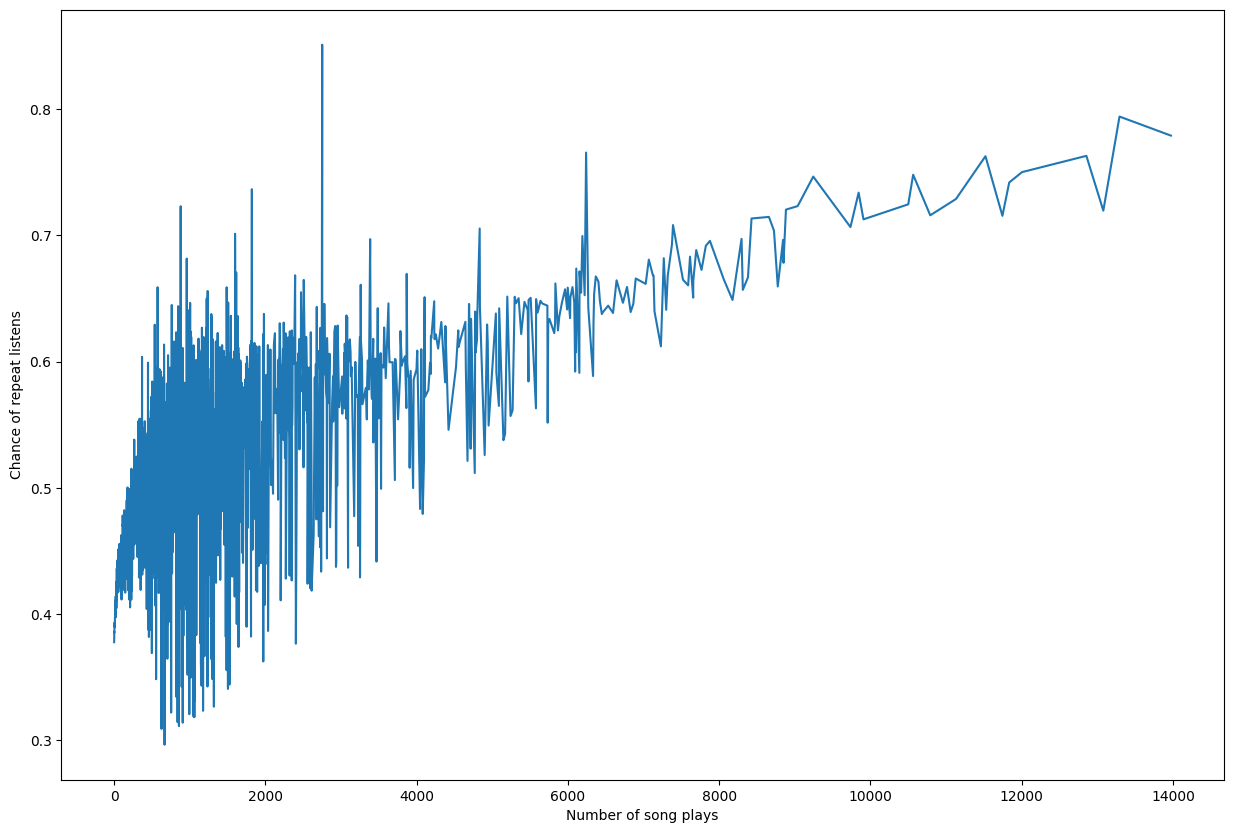

In [23]:
import matplotlib.pyplot as plt

f,axarray = plt.subplots(1,1,figsize=(15,10))
plt.xlabel('Number of song plays')
plt.ylabel('Chance of repeat listens')
plt.plot(x_plays, y_repeat_chance)

In [24]:
members_df.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,,4,20170126,20170613


In [25]:
outliers = (members_df['bd'] > 90) | (members_df['bd'] < 0)
# 0 is unspecified
members_df['bd'][outliers].shape[0]

28

For now I will treat those values as unspecified (0)

<Axes: >

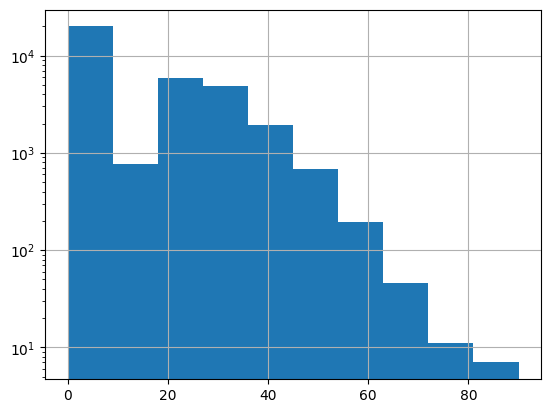

In [26]:
members_df['bd'][~outliers].hist(log=True)

Lognormal distribution, if we don't consider unspecified values

In [27]:
(members_df['gender']).value_counts()

gender
          19902
male       7405
female     7096
Name: count, dtype: int64

<Axes: >

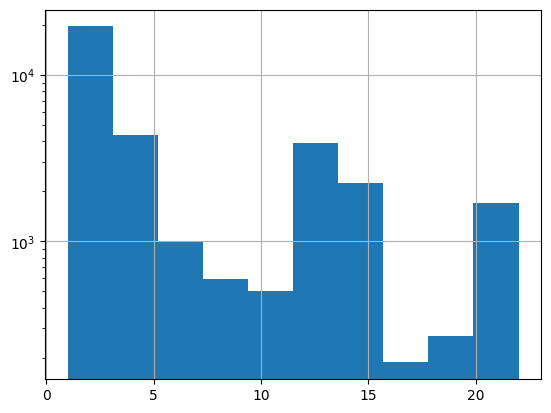

In [28]:
(members_df['city']).hist(log=True)

Multiple peaks, most users are from 5 cities.

# Data Preprocessing

**Short feature engineering summary is included afterwards**

Adding member features

In [29]:
members_df.loc[outliers.values, 'bd'] = 0
members_df.loc[members_df.gender =='', 'gender'] = 'unknown'
members_df['registration_init_time'] = pd.to_datetime(members_df['registration_init_time'], format='%Y%m%d')
members_df['expiration_date'] = pd.to_datetime(members_df['expiration_date'], format='%Y%m%d')
members_df['membership_days'] = members_df['expiration_date'].subtract(members_df['registration_init_time']).dt.days.astype(int)
members_df.drop(['registration_init_time', 'expiration_date'], axis=1, inplace=True)

In [30]:
def get_bd_cat(age):
    if age == 0:
        return "unknown"
    elif age < 20:
        return "<20"
    elif age < 22:
        return "<22"
    elif age <25:
        return "<25"
    return ">=25"

members_df['bd_cat'] = members_df['bd'].apply(get_bd_cat)
members_df.drop(['bd'], axis=1, inplace=True)

In [31]:
members_df

,msno,city,gender,registered_via,membership_days,bd_cat
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,unknown,7,2223,unknown
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,unknown,7,725,unknown
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,unknown,4,457,unknown
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,unknown,9,1,unknown
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,unknown,4,138,unknown
...,...,...,...,...,...,...
34398,Wwd/cudKVuLJ3txRVxlg2Zaeliu+LRUfiBmfrnxhRCY=,1,unknown,7,1399,unknown
34399,g3JGnJX6Hg50lFbrNWfsHwCUmApIkiv2M8sXOaeXoIQ=,4,male,3,937,<20
34400,IMaPMJuyN+ip9Vqi+z2XuXbFAP2kbHr+EvvCNkFfj+o=,1,unknown,7,1498,unknown
34401,WAnCAJjUty9Stv8yKtV7ZC7PN+ilOy5FX3aIJgGPANM=,1,unknown,7,701,unknown


In [32]:
def get_pop_genre(genre):
    if genre in pop_genres:
        return "genre_" + genre
    return "genre_other"

# Onehot encoding for the most popular genres.
songs_df['pop_gids'] = songs_df['genre_ids'].apply(
    lambda gids: list(map(get_pop_genre, gids.split('|'))))
songs_df = songs_df.join(songs_df.pop_gids.str.join('|').str.get_dummies())

In [33]:
def add_song_counts(df, train_df): 
    _dict_count_song_played = {k: v for k, v in train_df['song_id'].value_counts().items()}
    
    def get_count(s):
        try:
            return _dict_count_song_played[s]
        except KeyError:
            return 0
    
    df['count_song_played'] = df['song_id'].apply(get_count).astype(np.int64)
    return df

def add_song_features(df, train_df):
    def genre_id_count(x):
        if x == 'no_genre_id':
            return 0
        else:
            return x.count('|') + 1
    
    _mean_song_length = np.mean(df['song_length'])
    def smaller_song(x):
        if x < _mean_song_length:
            return 1
        return 0
    
    
    df['smaller_song'] = df['song_length'].apply(smaller_song).astype(np.int8)

    df['genre_ids'] = df['genre_ids'].fillna('no_genre_id')
    df['genre_ids_count'] = df['genre_ids'].apply(genre_id_count).astype(np.int8)
    
    df = add_song_counts(df, train_df)
    
    return df

It turns out that some of the songs are not present in songs_df, but since there are <200 total missing values for both train and test, I will be dropping them.

In [34]:
def preprocess(df):
    df = df.copy()
    df = df.merge(songs_df, on='song_id', how='left')
    df = df.merge(members_df, on='msno', how='left')
    
    df = add_song_features(df, train_df)
    one_hot_cols = ['source_system_tab', 'source_screen_name', 'source_type', 'gender', 'registered_via', 'bd_cat', 'city', 'language']
    df = df.drop(['genre_ids', 'artist_name', 'composer', 'lyricist', 'pop_gids']
                                 , axis=1)
    df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))
    df = pd.get_dummies(df, columns=one_hot_cols)
    
    return df

In [35]:
import gc
train_df_proc = preprocess(train_df)
del songs_df, members_df
gc.collect()

65

**To summarize**

*Member*
* added membership days feature
* split ages into categories (while setting outliers to unknown)

*Songs*
* added smaller song feature that indicates if song is shorter than average
* added genre_ids_count feature, self-explanatory
* added song_counts feature, that measures popularity of the song in train data.

*Dropped onehots that only appear in test*


In [38]:
corr = train_df_proc.sample(frac=0.2).corr(numeric_only=True)
sorted_corrs = corr['target'].sort_values(ascending=False)

highest_pos_corr = sorted_corrs.head(11) # rank + 10 others
highest_neg_corr = sorted_corrs.tail(10).dropna()
highest_idxes = np.concatenate([highest_pos_corr.index, highest_neg_corr.index])

<Axes: >

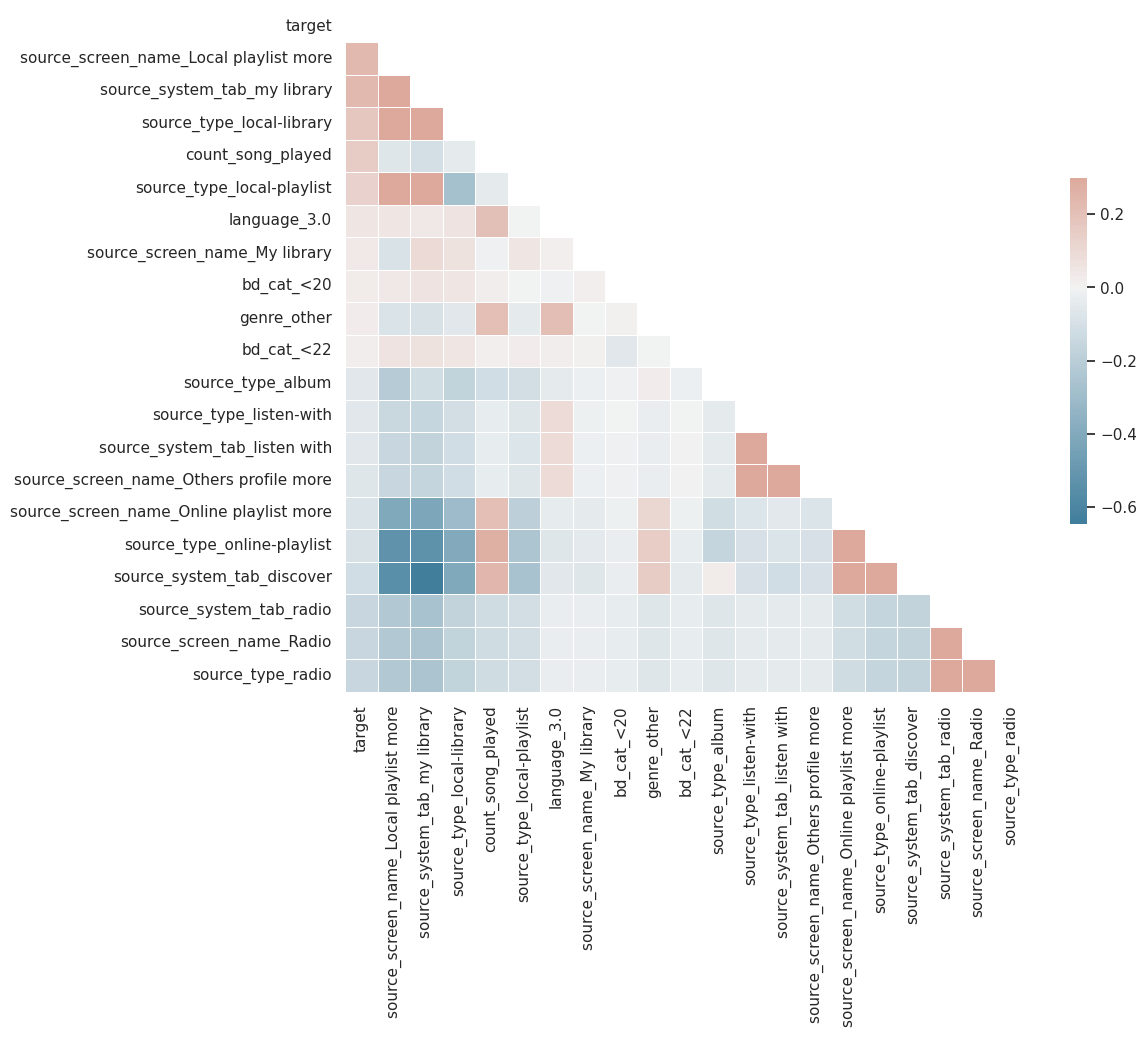

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")
corr = train_df_proc[highest_idxes].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We can see that my library and discover are heavily negatively correlated, while source types and song plays correlate mildly with target.

# Model training

**I will be using LightGCN model since we have large amounts of data and it is currently one of the better models out there**

For tree gradient boosting normalization of train dataset is not needed

Same for lightgcn

In [40]:
install = True
if install:
    !pip install -q pytorch_lightning
    !pip install -q torch_geometric

In [41]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns
import torch_geometric.data as pyg_data
import torch_geometric.utils as pyg_utils
import torch_geometric.nn as pyg_nn
import seaborn as sns
import shutil

from sklearn.model_selection import train_test_split

np.random.seed(42)

2024-04-30 17:59:22.053090: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 17:59:22.053246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 17:59:22.186049: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [42]:
config = {
    'NEGATIVE_SAMPLE_WEIGHT': 1,
    'MAX_EPOCHS': 5,
    'EMBEDDING_DIM': 64,
    'NUM_LAYERS': 4,
    'NUM_RECOMMENDATIONS': 100,
    'CHECKPOINT_PATH': '/kaggle/input/lightgcn-vk/pytorch/1/1/lightgcn-5.ckpt'
}

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
positives = train_df[train_df["target"] == 1].copy()
positives.rename(columns={"msno": "user", "song_id": "track"}, inplace=True)

# Отберем треки, которые прослушали минимум 15 раз.
track_counts = positives["track"].value_counts()
distinct_tracks = set(track_counts[track_counts >= 15].index.values)
data_filt = positives[positives["track"].isin(distinct_tracks)]
distinct_users = set(data_filt['user'])

print(f"Взаимодействий: {len(data_filt)}")
print(f"Уникальных треков: {len(distinct_tracks)}")
print(f"Уникальных пользователей: {len(distinct_users)}")

Взаимодействий: 3198026
Уникальных треков: 24017
Уникальных пользователей: 26824




В data_filt содержатся взаимодействия пользователей с треками. При этом, для идентификации треков и пользователей используются UserID, TrackID. Как среди UserID, так и среди TrackID могут иметь место гапы, из-за которых могут возникнуть дыры в таблице эмбеддингов.

По этой причине смаппим айдишники на индексы, начинающиеся с 0 и заканчивающиеся максимальным количеством пользователей / треков.


In [45]:
data_filt_sorted = data_filt[['user', 'track']].sort_values(by=['user'])

track_ids = np.sort(np.unique(data_filt_sorted['track']))
user_ids = np.sort(np.unique(data_filt_sorted['user']))

track_ix = np.searchsorted(track_ids, data_filt_sorted['track'].values)
user_ix = np.searchsorted(user_ids, data_filt_sorted['user'].values)

In [46]:
NUM_USERS = len(user_ids)
NUM_TRACKS = len(track_ids)
NUM_NODES = NUM_USERS + NUM_TRACKS

# Поскольку модель LightGCN из пакета PyG работает с гомогенными графами (один тип узлов), то
#  нам нужно как-то объединить узлы пользователей и треков без коллизий по индексам. Для этого идентификатору
#  узла каждого трека добавим сдвиг равный числу пользователей.
NODE_LABEL_SHIFT = NUM_USERS

print(f"Уникальных треков: {NUM_TRACKS}")
print(f"Уникальных пользователей: {NUM_USERS}")

Уникальных треков: 24017
Уникальных пользователей: 26824


In [47]:
assert (user_ids[user_ix] == data_filt_sorted['user'].values).min()
assert (track_ids[track_ix] == data_filt_sorted['track'].values).min()

In [48]:
user_item_interactions = torch.stack([
    torch.from_numpy(user_ix),
    # Сдвинем индексы узлов треков во избежание коллизий с узлами пользователей.
    torch.from_numpy(track_ix + NODE_LABEL_SHIFT)
])

item_user_interactions = torch.stack([
    user_item_interactions[1, :],
    user_item_interactions[0, :]
])

all_interactions = torch.cat([
    user_item_interactions,
    item_user_interactions
], axis = 1).to(device)

Класс NegativeSamplingDataset позволяет индексировать датасет. При обращении по индексу помимо положительного взаимодействия пользователь-трек (P) возвращается пара негативного взаимодействия пользователь-трек (N). Пара N генерируется и спользованием т.н. негативного семплирования. Негативное семплирование - это семейство стратегий для генерации негативных взаимодействий для обучения коллаборативных моделей на данных, в которых содержатся только позитивные взаимодействия.

In [49]:
SAMPLE_POSITIVE = 0
SAMPLE_NEGATIVE = 1

class NegativeSamplingDataset(td.Dataset):
  def __init__(self, user_track_interactions, index_subset=None, transform=None):
    # Подмножество индексов (для разбиения train / test)
    self.index_subset = index_subset
    # Все позитивные взаимодействия нашего датасета
    self.positive_edges_full_batch = user_track_interactions
    # Все негативные взаимодействия нашего датасета
    self.negative_edges_full_batch = None

    # Позитивные и негативные взаимодействия в срезе подмножества индексов
    self.positive_edges_sample = None
    self.negative_edges_sample = None

    # Сохраниим все позитивные взаимодействия нашего датасета
    self.init()

  def generate_negative_sample(self):
    # Сгенерируем негативные семплы. На каждого user в парах user -> item(+)
    #   генерируется пара user -> item(-). Подробнее о работе метода можно почитать по ссылке.
    # https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.structured_negative_sampling
    user_index, _, negative_item_index = \
      pyg_utils.structured_negative_sampling(self.positive_edges_full_batch, num_nodes=NUM_TRACKS)

    self.negative_edges_full_batch = torch.stack([
        user_index,
        negative_item_index
    ])

  def init(self):
    self.generate_negative_sample()

    # Получим положительные и негативные взаимодействия в срезе индексов для разбиения train / test.
    self.positive_edges_sample = self.positive_edges_full_batch[:, self.index_subset]
    self.negative_edges_sample = self.negative_edges_full_batch[:, self.index_subset]

  def __len__(self):
    return self.positive_edges_sample.shape[1]

  def __getitem__(self, idx):
    return (
        self.positive_edges_sample[:, idx],
        self.negative_edges_sample[:, idx]
    )

# Функция для объединения данных в батч, используемая в DataLoader
def collate_edges(edges: list) -> tuple:
    positive_edges = [edge[SAMPLE_POSITIVE] for edge in edges]
    negative_edges = [edge[SAMPLE_NEGATIVE] for edge in edges]

    positive_edges = torch.stack(positive_edges).t()
    negative_edges = torch.stack(negative_edges).t()

    return positive_edges.to(device), negative_edges.to(device)

train_ix, val_ix = train_test_split(np.arange(len(track_ix), dtype=np.int32), test_size=0.1)

music_dataset_train = NegativeSamplingDataset(user_item_interactions, train_ix)
music_dataset_val = NegativeSamplingDataset(user_item_interactions, val_ix)

music_dataloader_train = td.DataLoader(music_dataset_train, batch_size=3000, collate_fn = collate_edges)
music_dataloader_val = td.DataLoader(music_dataset_val, batch_size=3000, collate_fn = collate_edges)

**Определяем полезные хуки**
1. MetricTrackerHook - позволяет логировать метрики (в нашем случае - лосс) в конце каждой эпохи.
2. DatasetReloaderHook - позволяет перегенерировать негативные семплы в конце каждой эпохи.

In [50]:
class MetricTrackerHook(pl.Callback):
    def __init__(self):
      self.collection = {
          'train_loss': [],
          'val_loss': []
      }

    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule"):
      self.collection['train_loss'].append(trainer.logged_metrics['train_loss'].cpu().detach().numpy().item())

    def on_validation_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule"):
      self.collection['val_loss'].append(trainer.logged_metrics['val_loss'].cpu().detach().numpy().item())


class DatasetReloaderHook(pl.Callback):
  def __init__(self, dataset: NegativeSamplingDataset):
    self.dataset = dataset

  def ok_train_epoch_start(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule"):
    self.dataset.init()

In [51]:
NEGATIVE_SAMPLE_WEIGHT = config['NEGATIVE_SAMPLE_WEIGHT']

class GraphCollaborativeModel(pl.LightningModule):
    def __init__(self, all_adjacent_nodes, num_nodes: int, embedding_dim: int, num_layers: int):
        super().__init__()
        self.all_adjacent_nodes = all_adjacent_nodes
        self.gnn = pyg_nn.LightGCN(num_nodes, embedding_dim, num_layers)

    def compute_loss(self, user_item_positive, user_item_negative):
        # В forward метод LightGCN подается матрица смежности в виде (node_i <-> node_j),
        #  а также пары source_node -> dest_node (в нашем случае user -> track). Результатом forward пасса
        #  является скалярное перемножение эмбеддов пользователя и трека, см. формулу.

        pos_edge_ranking = self.gnn(self.all_adjacent_nodes, user_item_positive)
        neg_edge_ranking = self.gnn(self.all_adjacent_nodes, user_item_negative)

        return self.gnn.recommendation_loss(pos_edge_ranking, NEGATIVE_SAMPLE_WEIGHT * neg_edge_ranking)

    def step(self, data, batch_idx, label):
        user_item_positive, user_item_negative = data[0], data[1]

        loss = self.compute_loss(user_item_positive, user_item_negative)
        self.log(label, loss, prog_bar=True, on_step=False, on_epoch=True, batch_size=data[0].shape[1])
        return loss

    def training_step(self, data, batch_idx):
        return self.step(data, batch_idx, "train_loss")

    def validation_step(self, data, batch_idx):
        self.step(data, batch_idx, "val_loss")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [52]:
# Определяем модель
MAX_EPOCHS = config['MAX_EPOCHS']
EMBEDDING_DIM = config['EMBEDDING_DIM']
NUM_LAYERS = config['NUM_LAYERS']
model = GraphCollaborativeModel(all_interactions, NUM_NODES, EMBEDDING_DIM, NUM_LAYERS)

In [53]:
# Определяем все нужные нам хуки
checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1)
metric_tracker = MetricTrackerHook()
dataset_reloader_train = DatasetReloaderHook(music_dataset_train)
dataset_reloader_val = DatasetReloaderHook(music_dataset_val)

# Запускаем обучатор PytorchLightning
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=MAX_EPOCHS,
    callbacks=[
        checkpoint,
        metric_tracker,
        dataset_reloader_train,
        dataset_reloader_val
    ],
    enable_progress_bar=True,
)

In [54]:
#trainer.fit(model, music_dataloader_train, music_dataloader_val)

In [55]:
#shutil.copy(checkpoint.best_model_path, f"lightgcn.ckpt")

In [56]:
final_model = GraphCollaborativeModel.load_from_checkpoint(
    config["CHECKPOINT_PATH"],
    all_adjacent_nodes=all_interactions,
    num_nodes=NUM_USERS + NUM_TRACKS,
    embedding_dim=EMBEDDING_DIM,
    num_layers=NUM_LAYERS
)

In [57]:
all_embeddings = final_model.gnn.get_embedding(all_interactions.to('cuda'))

user_embeddings = all_embeddings[:NUM_USERS].detach().cpu().numpy().astype('float32')
item_embeddings = all_embeddings[NUM_USERS:].detach().cpu().numpy().astype('float32')

In [58]:
track2idx = {}
for i, track in enumerate(track_ids):
    track2idx[track] = i

In [59]:
user2idx = {}
for i, user in enumerate(user_ids):
    user2idx[user] = i

In [60]:
import gc
del train_ix, val_ix, music_dataset_train, music_dataset_val
del user_item_interactions, all_interactions
del item_user_interactions, positives, data_filt, data_filt_sorted
gc.collect()

41

**The idea is to use user and item embeddings learnt from lightGCN to improve CatBoost predictions**

Catboost has embedding_features support, however it is buggy and performs poorly, especially on GPU, so I will do it manually.

In [76]:
import gc

EMB_ZERO = np.zeros(EMBEDDING_DIM)

def get_emb_safe(embs, map_idx, item):
    try:
        key = map_idx[item]
        return embs[key]
    except KeyError:
        return EMB_ZERO
    
    
def build_embs(df):
    """
    Extracts embeddings for users and items, if they are present.
    Otherwise default embedding is returned.
    """
    n = df.shape[0]
    df_user_embs = np.zeros((n, EMBEDDING_DIM))
    df_track_embs = np.zeros((n, EMBEDDING_DIM))
    df_scores = np.zeros(n)
    for i, (user, track) in tqdm.tqdm(enumerate(df[['user', 'track']].values.tolist())):
        user_emb = get_emb_safe(user_embeddings, user2idx, user)
        track_emb = get_emb_safe(item_embeddings, track2idx, track)
        gcn_score = np.dot(user_emb, track_emb)
        df_scores[i] = gcn_score
        df_user_embs[i] = user_emb
        df_track_embs[i] = track_emb
    return df_user_embs, df_track_embs, df_scores


def cast_types(df, cat=False):
    """
    Helps with memory issues by boxing object features into categories
    Also casts float64 to float32, assuming no precision loss happens.
    """
    if cat:
        df['user'] = df['user'].astype('category')
        df['track'] = df['track'].astype('category')
    df[df.select_dtypes(['float64']).columns] = \
        df.select_dtypes(['float64']).apply(lambda x: x.astype('float32'))
    gc.collect()

def add_embeddings(df):
    """
    Builds user and track embeddings from given df, stores them in df_user and df_track dataframes.
    Each embedding is split into EMBEDDING_DIM columns with names corresponding to their index.
    
    """
    df.rename(columns={"msno": "user", "song_id": "track"}, inplace=True)
    cast_types(df, True)
    
    df_user_embs, df_track_embs, df_scores = build_embs(df)
    
    df_user = pd.DataFrame(np.vstack(df_user_embs))
    cast_types(df_user)
    
    df_user.columns =[f'user_emb_{i}' for i in range(EMBEDDING_DIM)]
    
    df_track = pd.DataFrame(np.vstack(df_track_embs))
    cast_types(df_track)
    df_track.columns =[f'track_emb_{i}' for i in range(EMBEDDING_DIM)]
    
    df['score'] = df_scores
    del df_scores, df_user_embs, df_track_embs
    gc.collect()
    
    return  df, df_user, df_track

In [110]:
train_df_final, dfu, dft = add_embeddings(train_df_proc)
del train_df_proc
gc.collect()

75812

Since train set is large, 0.15 is enough for validation purposes.

Splitting indices is way cheaper memory-wise

# Parameter tuning

In [131]:
train_ix, val_ix = train_test_split(np.arange(len(train_df_final),
                                              dtype=np.int32), test_size=0.15,
                                   stratify=train_df_final['target'],
                                   random_state=42)

train_ix, test_ix = train_test_split(np.arange(len(train_ix),
                                              dtype=np.int32), test_size=0.15,
                                   stratify=train_df_final['target'].iloc[train_ix],
                                    random_state=42)


X_cols = train_df_final.columns.drop(['target', 'user', 'track'])
y_col = 'target'

In [132]:
val_df = train_df_final.iloc[val_ix].copy()
val_df['group_id'] = val_df.groupby('user', observed=True).ngroup()
val_df = val_df.drop(['user', 'track'], axis=1)

In [133]:
test_df = train_df_final.iloc[test_ix].copy()
test_df['group_id'] = test_df.groupby('user', observed=True).ngroup()
test_df = test_df.drop(['user', 'track'], axis=1)

**Normally for ranking tasks I would use CatBoostRanker, however in this case the task is closer to CTR prediction and can be treated as Binary Classification problem.**

This way we do not have to assign and split by groups until metric calculations.

In [134]:
from catboost import CatBoostClassifier, Pool

train_pool = Pool(
    data=train_df_final[X_cols].iloc[train_ix],
    label=train_df_final[y_col].iloc[train_ix]
)

val_pool = Pool(
    data=train_df_final[X_cols].iloc[val_ix],
    label=train_df_final[y_col].iloc[val_ix]
)


Training on GPU is less accurate but way faster. 

This will allow me to tune hyperparameters, which in turn will equalize cpu and gpu in terms of quality and might improve the results.

In [178]:
best_params = {
    'iterations': 3000,
    'verbose': 300,
    'random_seed': 42,
    "use_best_model":True,
    "random_strength":3,
    "max_depth": 15,
    'l2_leaf_reg': 2.5835,
    'early_stopping_rounds': 300,
    'task_type': "GPU",
    'devices': '0'
}

In [179]:
from sklearn.metrics import ndcg_score

def get_val_ndcg(df, ix, preds):
    """
    Calculates average NDCG@20 for all groups in given df
    """
    df = df.copy()
    df['preds'] = preds
    df['target'] = train_df_final.iloc[ix]['target']
    grouped = df.groupby('group_id')
    ndcgs = []
    for name, group in grouped:
        y_pred = group['preds'].values.reshape(1, -1)
        y_true = group['target'].values.reshape(1, -1)
        if y_pred.shape[1] == 1:
            continue
        ndcgs.append(ndcg_score(y_true, y_pred, k=20))
    return np.array(ndcgs).mean()

**В качестве loss функции будут Logloss, что в нашем случае совпадает с CrossEntropy, она бинарная**


In [180]:
import optuna

def objective(trial):

    param = {
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 5.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 6, 15),
        "iterations": 500
    }
    cp = best_params.copy()
    cp.update(param)
    model = CatBoostClassifier(**cp)

    model.fit(train_pool, eval_set=val_pool, use_best_model=True, verbose=False)

    preds = model.predict(val_df)


    return get_val_ndcg(val_df, val_ix, preds)

In [181]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)
# print('Best value:', study.best_trial.value)

In [ ]:
final_params = best_params.copy()
#final_params.update(study.best_trial.params)
model = CatBoostClassifier(**final_params)
model.fit(train_pool, eval_set=val_pool, use_best_model=True)

0:	learn: 0.6884092	test: 0.6885966	best: 0.6885966 (0)	total: 609ms	remaining: 30m 27s
300:	learn: 0.5932489	test: 0.6011977	best: 0.6011977 (300)	total: 3m 2s	remaining: 27m 19s
600:	learn: 0.5765171	test: 0.5870851	best: 0.5870851 (600)	total: 6m 7s	remaining: 24m 25s
900:	learn: 0.5606985	test: 0.5741321	best: 0.5741321 (900)	total: 9m 11s	remaining: 21m 25s
1200:	learn: 0.5483942	test: 0.5643470	best: 0.5643470 (1200)	total: 12m 17s	remaining: 18m 24s
1500:	learn: 0.5376275	test: 0.5559553	best: 0.5559553 (1500)	total: 15m 22s	remaining: 15m 21s
1800:	learn: 0.5282009	test: 0.5487186	best: 0.5487186 (1800)	total: 18m 27s	remaining: 12m 17s
2100:	learn: 0.5194544	test: 0.5421040	best: 0.5421040 (2100)	total: 21m 33s	remaining: 9m 13s


In [ ]:
val_preds = model.predict(val_df)
test_preds = model.predict(test_df)
val_ndcg = get_val_ndcg(val_df, val_ix, val_preds)
test_ndcg = get_val_ndcg(test_df, test_ix, test_preds)

In [ ]:
print(f'Validation NDCG@20: {val_ndcg}')
print(f'Test NDCG@20: {test_ndcg}')

**Let's also look at classification metrics**

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.plot(model.evals_result_["learn"]["Logloss"], label="Training Logloss")

plt.axvline(x = model.best_iteration_, color = 'r', label = 'model cutoff')

plt.plot(model.evals_result_["validation"]['Logloss'], label="Validation Logloss")
plt.xlabel("Number of trees (iterations)")
plt.ylabel("Value")
plt.legend()

In [ ]:
from sklearn.metrics import classification_report

y_test = train_df_final.iloc[test_ix]['target']
print(classification_report(test_preds, y_test))

# Possible Improvements
1. Train a neural network using LightGCN embeddings (or ALS)
  Architecture is similar to [this](https://github.com/lystdo/Codes-for-WSDM-CUP-Music-Rec-1st-place-solution/blob/master/nn_structure.pdf)
2. Try stacking using trained NN, CatBoost and LightGCN
3. Try weighted predictions (e.g. 0.6 * CatBoost + 0.4 * LightGCN).
4. Training LightGCN with more layers / for more epochs to get better embeddings, find better CatBoost parameters